<img  src="https://www.bcm.edu/themes/custom/bcm_bootstrap_subtheme/css/../images/BCM-90x90.svg" alt="Drawing" style="height: 100px;float: left;"/>


# Mask or no mask: A decision guide for teachers, parents, and students

* August, 2021
* Institute for Clinical & Translational Research, Baylor College of Medicine

# Context

With  increasing incidences of [COVID-19 infections in the Greater Houston Area](https://www.tmc.edu/coronavirus-updates/daily-new-covid-19-positive-cases-for-the-greater-houston-area/) and  students returning to school, informed decisions must be made regarding teacher and student continuous masking recommendations.

As of today (August 21),
1. An executive order is in place which [prohibits Texas government funded entities from mandating mask wearing on premises](https://gov.texas.gov/news/post/governor-abbott-issues-executive-order-prohibiting-government-entities-from-mandating-masks).
2. [Houston ISD](https://www.houstonisd.org/) is one of [a handful of schools in the Houston area](https://www.khou.com/article/news/health/coronavirus/masks-houston-school-districts-covid-coronavirus/285-25154fcd-97ae-4d8b-9444-be77a0b58f89) which does have a mask wearing mandate in place.
3. Colleges in the our area have established differing policies. Notably, Rice University has [COVID policies that mandate mask wearing indoors](https://coronavirus.rice.edu/policies). 

To provide quantitative insight into these mixed stances, we ran a targeted simulation using our [COVID-19 Outbreak Simulator](https://ictr.github.io/covid19-outbreak-simulator/) to compare the number of COVID-cases that develop in schools that mandate or do not mandate mask wearing.

**Disclaimer**: This report was prepared by researchers in the [Institute for Clinical & Translational Research](https://www.bcm.edu/research/research-offices/institute-for-clinical-translational-research), Baylor College of Medicine. It uses a limited model to predict the impact of mask wearing on COVID-19 incidences in public schools in the Greater Houston Area, and does not necessarily reflect the impact of other site specific COVID-prevention policies that may be in place at each of these schools.

# Conclusions

The delta variant is highly infectious. With the Houston's existing high regional community infection rate we found that:

1. Almost all schools will have at least 1 school-acquired infection.
2. If masks are worn at all the time, `0.8%` of high school students will become infected at school. This risk is, however, lower than getting infected from the community (`2.8%`). The proportions for school and community-based infections are higher for elementary schools(`1.0%` and `3.0%` respectively) because students in elementary schools are not vaccinated.
3. If masks are not worn at all, `15.4%` of high school students will be infected within a month, and one fifth (`21.0%`) all students in elementary schools will be infected. Again, we are assuming that there will be no post-infection contact tracing and testing will be performed so asymptomatic carriers will continue to attend school and infect others.
4. The proportion of students who will be isolated due to the showing of symptoms will be `1.8%` for high school students and `2.1%` for elementary school students if masks are worn. About `7.7%` of students in high school and `9.7%` of students in elementary schools will be isolated if masks are not worn.
5. If community infection rate drops to 1/4 of the current level (around `500` daily new cases in Harris County or `750` in the Greater Houston Area), students who will be isolated due to COVID-19 infections will be much lower, which will be around `0.5%` if masks are worn at all time, and `2.5%` if masks are not worn.
6. If we increase the vaccination coverage to an almost ideal level at which  `90%` of all teachers are vaccinated and `60%` of high school students are vaccinated, there will still be a significant number of breakthrough cases.

These results reflect our assumptions that

1. `60%` of teachers are vaccinated, `30%` of high school students are vaccinated, and no students in elementary schools are vaccinated.
2. Students in high schools have more physical interactions whereas students in elementary schools mostly interact with their own classmates.
3. Around `20%` of all students and teachers have already been infected and recovered from COVID.

Please see the `Methods` section for details.

# Results

We ran `10,000` replicate simulations for each scenario and the following table lists 

1. **Community infection rate (per mission)**, which is assumed to be `1600/million` now, but we also provide results for `400/million` for comparison purposes.
2. **School** can be either high school or elementary school, which differ by school size and student movement patterns.
3. **Vaccination Coverage (teachers / students)**. In addition to the assumed vaccination rates at the present time, we also simulated scenarios when `90%` of teachers are vaccinated and `60%` of high school students are vaccinated.
4. **Mask wearing**, can be no mask, with mask, or non-mandatory, for which assume 50% of students and teachers will wear mask.
5. **Percentage of schools that have no school-transmitted infection**. Students may be infected with the virus from home, but not from school.
6. **Percentage of students infected in community**. This number reflects risks from the community infection rate, vaccine coverage, and the proportion of students who have recovered from COVID infections.
7. **Percentage of students infected from school**. This number reflects the risk of the schools from which students get infected with the coronavirus.
8. **Percentage of students isolated due to COVID symptoms**. This number reflects the overall students who are impacted, including students who have been infected from both school and community, but exclude students who do not show any COVID symptoms.

The complete results can be downloaded from [our GitHub repository](https://github.com/ictr/back-to-school/blob/main/results.xlsx).

In [64]:
## This function retrieves results for all contexts as a Python DataFrame.

import pickle
import os
import pandas as pd

scratch_dir = '#ictr-scratch/bpeng/back_to_school/'

def get_results(contexts):
    all_res = []
    for context in contexts:
        res_file = path(f'{scratch_dir}/{context["name"]}.pickle')
        if not res_file.exists():
            print(f'Missing {context["name"]}')
            continue
        with open(res_file, 'rb') as infile:
            loaded = pickle.load(infile)
            #if not 'num_replicates' in loaded or loaded["num_replicates"] < context["num_replicates"]:
            #    print(f'WRONG {context["name"]}')
                #os.remove(res_file)
                #continue
            res = {
                'Community Infection Rate (per million)': int(context['community_infection_rate'] * 1000000),
                'School': context['school'].split('_')[-1],
                'Vaccination Coverage (teachers / students)': context['vac_coverage_text'],
                'Mask wearing': context['mask_wearing'],                 
            }
            res.update(loaded)            
            res['Percentage of students infected in community, with 95% CI'] = '{:.1f} [{:.1f}, {:.1f}]'.format(
                res['Percentage of students infected in community'],
                res['Percentage of students infected in community, 2.5% Quantile'],
                res['Percentage of students infected in community, 97.5% Quantile'],
            )
            res['Percentage of students infected at school, with 95% CI'] = '{:.1f} [{:.1f}, {:.1f}]'.format(
                res['Percentage of students infected at school'],
                res['Percentage of students infected at school, 2.5% Quantile'],
                res['Percentage of students infected at school, 97.5% Quantile'],
            )
            res['Percentage of students isolated due to COVID symptoms, with 95% CI'] = '{:.1f} [{:.1f}, {:.1f}]'.format(
                res['Percentage of students isolated due to COVID symptoms'],
                res['Percentage of students isolated due to COVID symptoms, 2.5% Quantile'],
                res['Percentage of students isolated due to COVID symptoms, 97.5% Quantile'],
            )
            res['Mask wearing %'] = int(res['Mask wearing'].split('%')[0])

            res.pop('num_replicates', None)
            all_res.append(res)

    all_res = pd.DataFrame(all_res)
    return all_res

pd.options.display.float_format = '{:,.1f}'.format


In [65]:
%preview  res_display

res = get_results(all_contexts)

res_display = res[['Community Infection Rate (per million)', 'School',
       'Vaccination Coverage (teachers / students)', 'Mask wearing',
       'Percentage of schools with no school-transmitted infections %',
       'Percentage of students infected in community, with 95% CI',
       'Percentage of students infected at school, with 95% CI',
       'Percentage of students isolated due to COVID symptoms, with 95% CI']]

with pd.ExcelWriter(path(f'results.xlsx'), engine='xlsxwriter') as writer: 
    res.to_excel(writer, index=False, sheet_name='All')
    
    workbook  = writer.book
    
    fmt_num = workbook.add_format({'num_format': '0.00'})
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True})
    
    worksheet = writer.sheets["All"]
    worksheet.set_column('J:P', None, fmt_num)
    #worksheet.set_row(0, 0, header_format)

>>> res_display:

,Community Infection Rate (per million),School,Vaccination Coverage (teachers / students),Mask wearing,Percentage of schools with no school-transmitted infections %,"Percentage of students infected in community, with 95% CI","Percentage of students infected at school, with 95% CI","Percentage of students isolated due to COVID symptoms, with 95% CI"
0,1600,high,60% / 30%,0% mask,0.0,"2.7 [1.6, 3.9]","15.4 [5.1, 28.6]","7.8 [3.1, 14.1]"
1,1600,high,60% / 30%,10% mask,0.0,"2.7 [1.6, 3.9]","12.1 [4.0, 23.1]","6.6 [2.8, 12.0]"
2,1600,high,60% / 30%,20% mask,0.0,"2.7 [1.8, 3.9]","9.4 [3.1, 18.2]","5.6 [2.4, 10.0]"
3,1600,high,60% / 30%,30% mask,0.0,"2.7 [1.8, 3.9]","7.3 [2.4, 14.1]","4.8 [2.1, 8.5]"
4,1600,high,60% / 30%,40% mask,0.0,"2.7 [1.8, 3.9]","5.5 [1.8, 11.0]","4.1 [1.8, 7.2]"
5,1600,high,60% / 30%,50% mask,0.0,"2.8 [1.8, 3.9]","4.2 [1.4, 8.5]","3.5 [1.6, 6.1]"
6,1600,high,60% / 30%,60% mask,0.0,"2.8 [1.8, 3.9]","3.2 [0.9, 6.4]","3.1 [1.4, 5.2]"
7,1600,high,60% / 30%,70% mask,0.0,"2.8 [1.8, 4.0]","2.4 [0.6, 4.8]","2.7 [1.2, 4.5]"
8,1600,high,60% / 30%,80% mask,0.0,"2.8 [1.8, 3.9]","1.7 [0.4, 3.5]","2.4 [1.1, 3.9]"
9,1600,high,60% / 30%,90% mask,0.1,"2.8 [1.8, 4.0]","1.2 [0.2, 2.5]","2.1 [1.0, 3.5]"


In [66]:
res.to_csv(path('#home/BoPeng/back-to-school/results.csv'))

In [67]:
%cd #home/BoPeng/back-to-school/
res = read.csv('results.csv', check.names=FALSE)

/home/bpeng/BoPeng/back-to-school

In [100]:
library(ggplot2)
library(gridExtra)

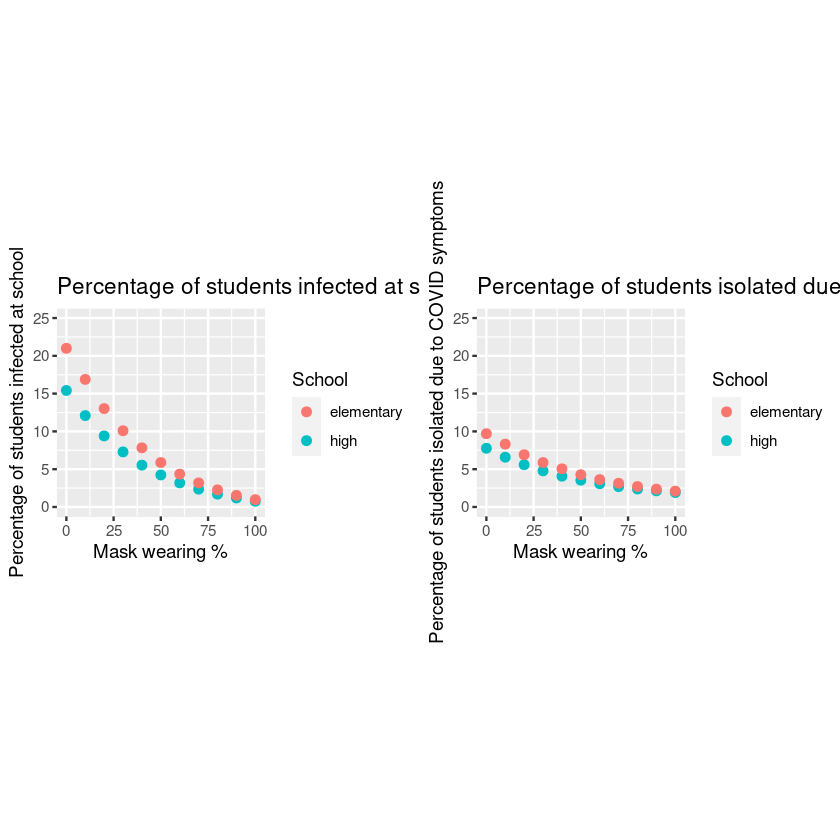

In [194]:
res_1600 = res[res$`Community Infection Rate (per million)` == 1600, ]
res_1600_cur_vac = rbind(
    res_1600[res_1600$`Vaccination Coverage (teachers / students)` == '60% / 30%',],
    res_1600[res_1600$`Vaccination Coverage (teachers / students)` == '60% / 0%',])

#geom_text(aes(hjust=0, vjust=0,
#                label=round(`Percentage of students infected at school`, 2)),
#                size=5) +
#geom_errorbar(aes(ymin=`Percentage of students infected at school, 2.5% Quantile`,
#                    ymax=`Percentage of students infected at school, 97.5% Quantile`),
#                colour="black", width=.1) +    

p1 <- ggplot(res_1600_cur_vac,  aes(x=`Mask wearing %`, y=`Percentage of students infected at school`) ) + 
  geom_point(aes(col=School), size=2) +  theme(aspect.ratio = 1) +   
  coord_cartesian(xlim=c(0, 100), ylim=c(0, 25)) + 
  labs(title="Percentage of students infected at school")
p2 <- ggplot(res_1600_cur_vac, aes(x=`Mask wearing %`, y=`Percentage of students isolated due to COVID symptoms`) ) + 
  geom_point(aes(col=School), size=2) + theme(aspect.ratio = 1) +   
  coord_cartesian(xlim=c(0, 100), ylim=c(0, 25)) + 
  labs(title="Percentage of students isolated due to COVID symptoms"
       )

ggsave('school.png', plot=grid.arrange(p1, p2, nrow = 1), width=3000, height=1400, units='px', dpi=240)

The following figure lists the perentage of students who might get infected at school, or isolated due to COVID symptoms (students may be infected both at school or from community, but my not show symptoms), under the assumptions that `60%` of teachers are vaccinated, `30%` of high school students are vaccinated, and no student from elementary school is vaccinated.

> school.png (120.1 KiB):

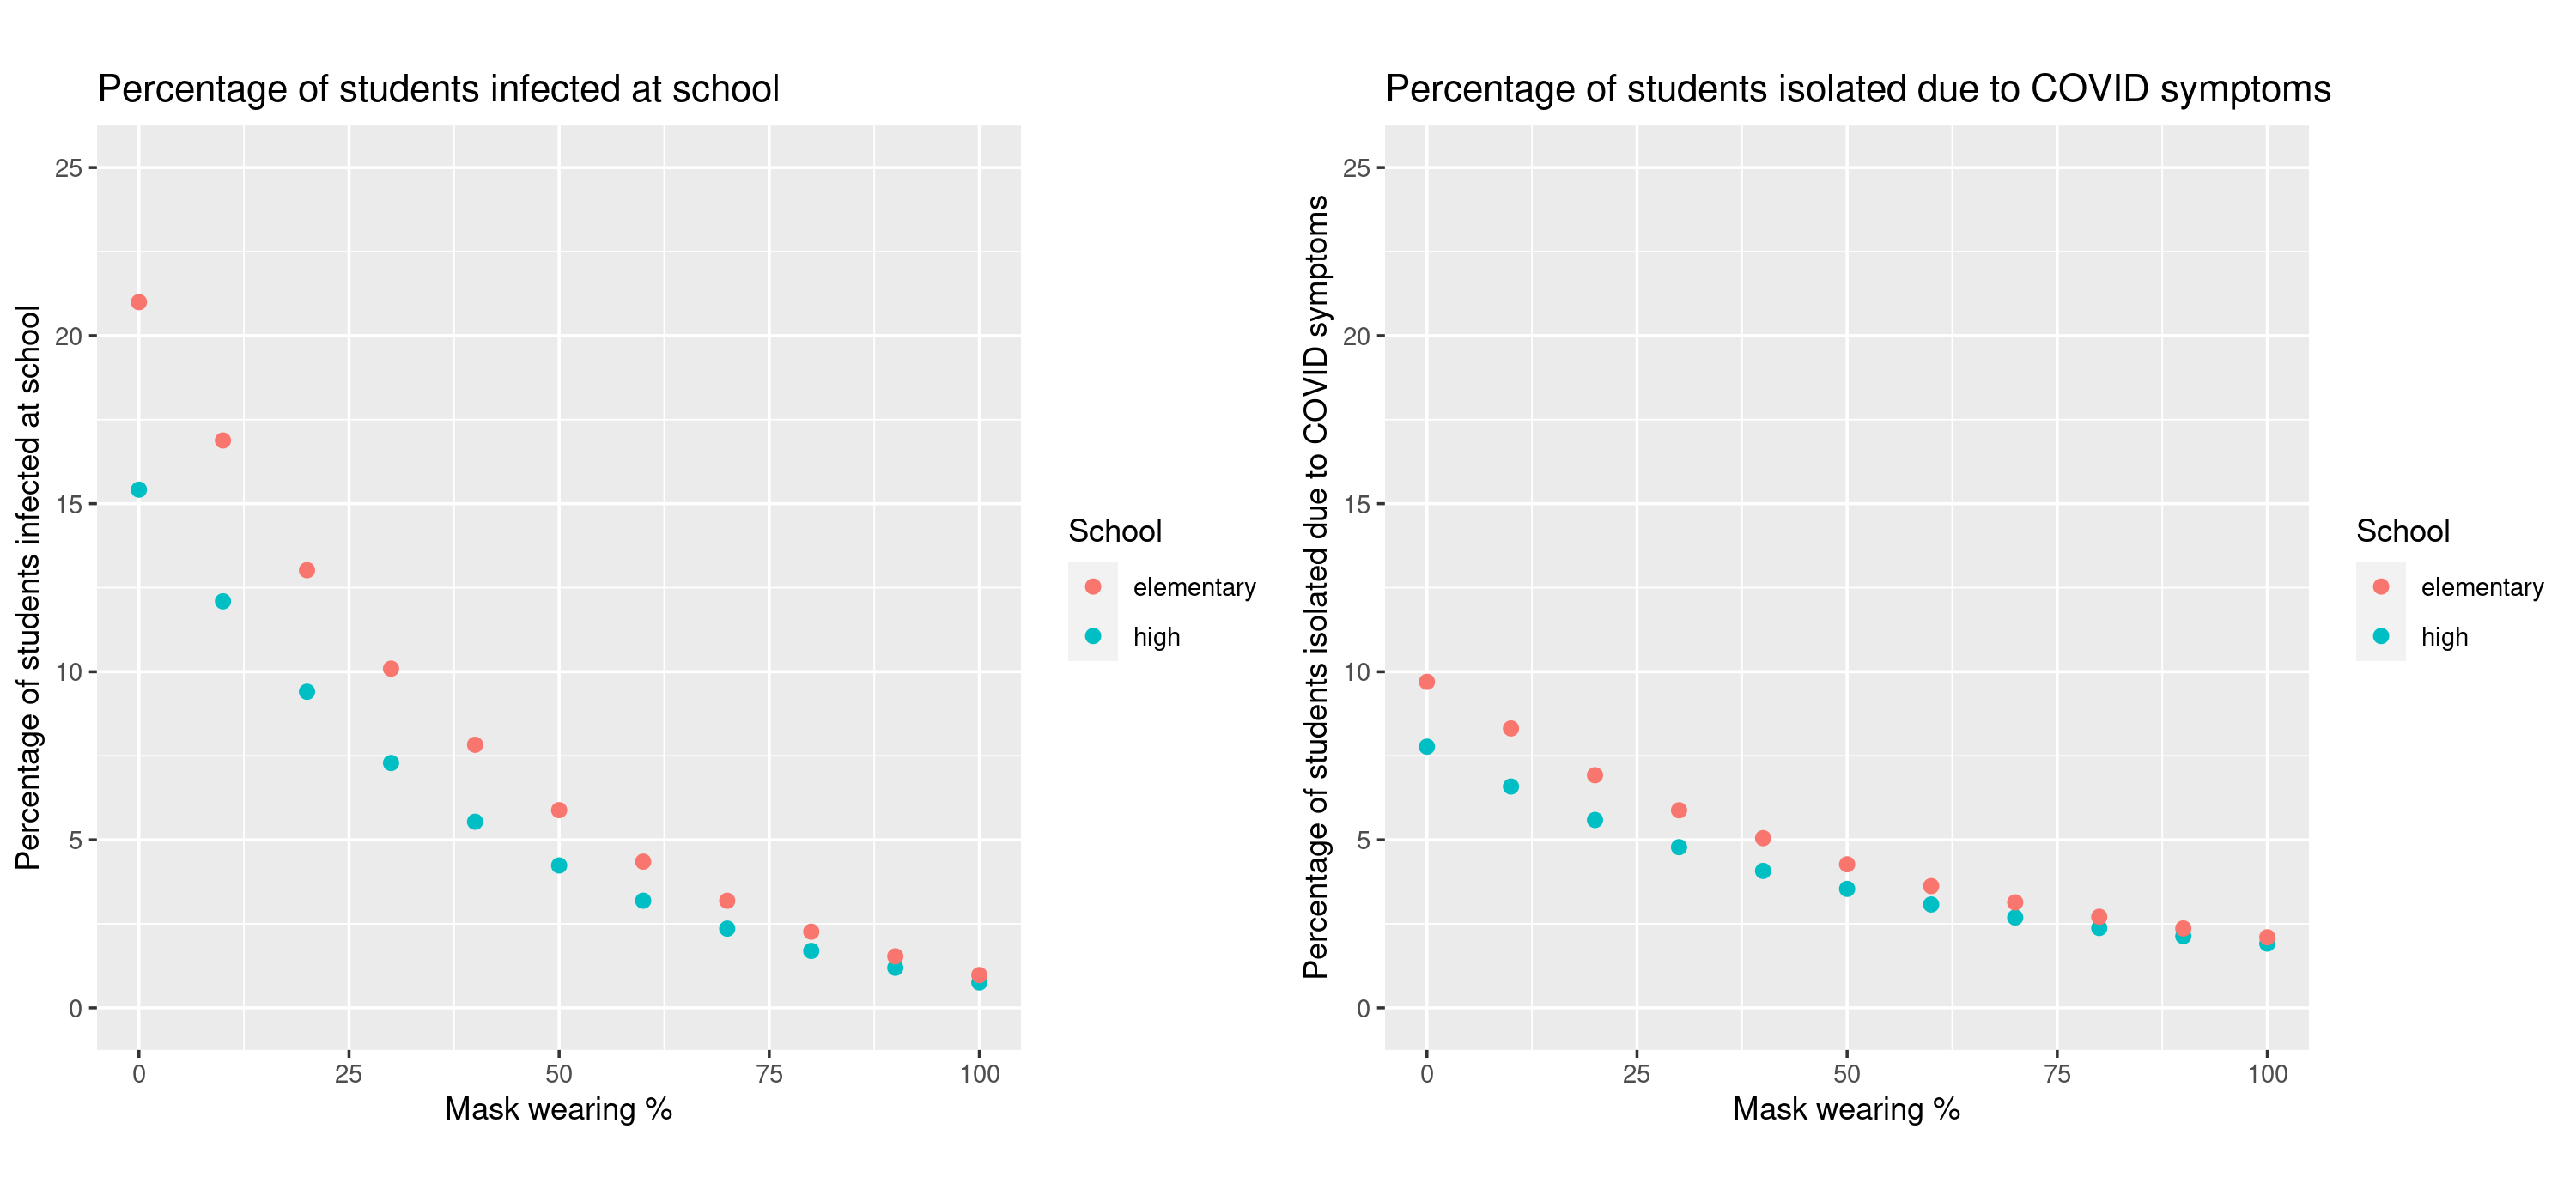

In [195]:
%preview school.png

# Methods

We assume that all students and teachers live in the same "community" that is subject to a fixed "community infection rate", which is the probability that people are infected. People who are infected from the community would go to school, with or without mask, and have the same probability of infecting others. People who show symptoms are isolated for 10 days before they go back to school, at which time they have recovered and are largely immune to reinfection. We **do not yet model other post-infection reactions such as contact tracing and testing**, which are being employed by many schools and universities to prevent the spread of the coronavirus.

We assume 

* **Community infection rate (CIR)**: CIR is the actual community rate of infection and is used to model the probability at which people are infected. The actual number will differ from the Public Health reported confirmed case numbers due to reporting delays and the sufficiency of testing (see https://ourworldindata.org/covid-models for an expanded discussion). As of writing, 
    * There are around `2000` confirmed cases per day in the Harris County with `4.7 M` people, or
    * Around `3000` confirmed cases per day in the Greater Houston Area with a population of about `9` million,
    
  so the raw CIR is about `400 / million`. Using a popular method to adjust for the under-reporting of actual CIR, namely multiplying the number of confirmed cases by a factor of 4, we use **1600 / million** as the CIR for the Greater Houston Area. Note that the estimates from [The Institute for Health Metrics and Evaluation (IHME) an independent global health research center at the University of Washington](https://covid19.healthdata.org/global?view=cumulative-deaths&tab=trend) is around 2121 per million for the state of Texas.

* **Vaccination coverage**: According to government report, 45.7% of people are fully vaccinated in Texas. We assume that adults (teachers) have higher vaccination rates and assume that
    * `60%` of teachers and staff are vaccinated in both high schools and elementary schools.
    * `30%` of students are vaccinated in high schools.
    * Students in elementary schools are not vaccinated.
    * For comparison purposes, we also simulated scenarios under which `90%` of teachers are vaccinated and `60%` of high school students are vaccinated.
  
* **Size of schools**: According to online information, we assume that
    * High schools have 800 students with a 15:1 teacher student ratio (50 teachers, 50 staff).
    * Elementary schools have 500 students with a 15:1 teacher student ratio (30 teachers, 30 staff).
    
* **Transmissibility of virus**: The highly contagious delta variant has become the most prevalent version of COVID-19 in the country, and also in the state of Texas. The delta variant has 
    * A reproduction number of around `6.5` for symptomatic cases (range 5-8)
    * A reproduction number of `4.6` for asymptomatic carriers because we assume that asymptomatic carriers are 70% infectious compared to symptomatic carriers.
    * An average incubation period of `4.4`
    * `30%` of people will remain asymptomatic after being infected.
    * `20%` of the population (teachers and students) have already been infected, and recovered. They are less susceptible to another infection (`50%` reduction) and have lower viral load (`50%` reduction) if they are infected.    
    
* **Infection patterns**:
    * We assume that students and teachers will spend half of the "interacting" time at home and half of the time at school (8 hours each), so only about half of the infection events will happen at school. 
    * We assume that students in elementary schools are divided into `25` classes with `20` students each. Because students in elementary schools usually only interact with their classmates and teachers, we assume that each student will interact with the rest of the class (`19` students), `3` teachers, and `5` random students they interact at hall way or cafeterias.
    * We assume that students in high schools are well mixed so everyone can infect any other student, teacher, or staff.

* **Post-infection reaction**:
    * We assume that no testing will be performed and students will only be sent home and isolate for 10 days after they have shown symptoms of COVID-19.
    * Teachers and students will be allowed to go back to school after 10 days. They are assumed to be recovered, but can be infected again.
    
* **Efficacy of vaccine**: Most Houstonians were vaccinated with the Pfizer vaccine, which is reported to
    * Has `42%` efficacy for preventing infection
    * Reduces viral loads of infected people by around `50%`
    * Has around `50%` efficacy for preventing secondary infection.
 
* **Duration of simulation**: We simulate the operation of schools for a month (28 days, 20 working days).
 
* **Mask wearing**: We simulate three scenarios,
   * no mask
   * with mask, which causes 80% reduction in the transmission of the virus
   * some mask, which corresponds to the case of no mandated mask wearing, perhaps 50% of people will wear mask and lead to 40% reduction in the transmission of the virus.
 

We output the number of infections and symptomatic cases in both high schools and elementary schools.


In [1]:
import pandas as pd

vac_specs = {
    'T60S30': {'teachers': 0.6, 'students': 0.3},
    'T80S60': {'teachers': 0.9, 'students': 0.6},
}

school_spec = {
    'high': {'teachers': 'T=100', 'students': 'S=800'},
    'elementary': {'teachers': 'T=60', 
                   'students': ' '.join([f'S{i+1}=20' for i in range(25)])
                  },
}

communities = {
    'C1600': dict(community_infection_rate=1600 / 1000000),
    'C400': dict(community_infection_rate=400 / 1000000),
}


variants = {
    'delta': dict(sym_r0=[5, 8], asym_r0=[5*0.75, 8*0.75], incu_period=4.4, name='B.1.617.2', prop_asym_carriers=0.3),
}

# 86/76 for alpha; 76/42 for delta; and 75-81% protection against hospitalizations.
vaccination_specs = {
    'pfizer': dict(
            delta=dict(vac_immunity=[0.42, 0.38], vac_infectivity=[0.5, 0.5]),
        ),    
}

distancing_spec = {
    '0% mask': 1,
    '10% mask': 1 - 0.8 * 0.1,
    '20% mask': 1 - 0.8 * 0.2,
    '30% mask': 1 - 0.8 * 0.3,
    '40% mask': 1 - 0.8 * 0.4,
    '50% mask': 1 - 0.8 * 0.5,
    '60% mask': 1 - 0.8 * 0.6,
    '70% mask': 1 - 0.8 * 0.7,
    '80% mask': 1 - 0.8 * 0.8,
    '90% mask': 1 - 0.8 * 0.9,
    '100% mask': 0.2,    
}

def get_single_context(
    school,
    vac_coverage,
    distancing,
    community,
):
    variant = 'delta'
    vac_name = 'pfizer'
    
    vac_teacher = vac_specs[vac_coverage]['teachers']
    vac_student = vac_specs[vac_coverage]['students']
    if school == 'high':
        vac_proportion = f'T={vac_teacher:.1f} S={vac_student:.1f}'
        vac_coverage_text = f'{int(vac_teacher*100)}% / {int(vac_student * 100)}%'
    else:
        vac_proportion = f'T={vac_teacher:.1f} ' + ' '.join([f'S{i+1}=0' for i in range(25)])
        vac_coverage_text = f'{int(vac_teacher*100)}% / 0%'
        
    return dict(
        name=f'{community}_{school}_{vac_coverage}_{distancing.replace("% mask", "")}',
        school=school,
        mask_wearing=distancing,
        community=community,
        #
        community_infection_rate=communities[community]['community_infection_rate'],
        #
        vac_proportion=vac_proportion,
        vac_coverage_text=vac_coverage_text,
        
        vac_immunity=' '.join(str(x) for x in vaccination_specs[vac_name][variant]['vac_immunity']),
        vac_infectivity=' '.join(str(x) for x in vaccination_specs[vac_name][variant]['vac_infectivity']),
                
        # constant
        pop_size=school_spec[school]['teachers'] + ' ' + school_spec[school]['students'],
        prop_asym_carriers=variants[variant]["prop_asym_carriers"],
        
        sym_r0=f'{variants[variant]["sym_r0"][0]:.2f} {variants[variant]["sym_r0"][1]:.2f}',
        asym_r0=f'{variants[variant]["asym_r0"][0]:.2f} {variants[variant]["asym_r0"][1]:.2f}',
        incu_period=variants[variant]["incu_period"],        
        # use 0.5 to assume that half of the infections will be to
        # non-school members
        distancing_multiplier=distancing_spec[distancing] * 0.5,
        duration=20,
        immunity_of_recovered=0.5,
        infectivity_of_recovered=0.5,  
        prop_recovered = 0.2,
        #
        # use more replicates for lower community infection rate to save computing time
        num_replicates=10000)

def get_contexts(
    school_cases=[],  
    vac_coverage_cases=[],
    distancing_cases=[],    
    community_cases=[],
):
    contexts = []
    for community in community_cases:
        for school in school_cases:
            for vac_coverage in vac_coverage_cases:
                for distancing in distancing_cases:            
                    contexts.append(
                        get_single_context(school, vac_coverage, distancing, community))
    # remove duplicate
    return contexts


In [2]:
%preview cases -l 400

high_contexts = get_contexts(
    school_cases=['high', ],
    vac_coverage_cases=vac_specs.keys(),
    community_cases=communities.keys(),
    distancing_cases=distancing_spec.keys(),
)

elementary_contexts = get_contexts(
    school_cases=['elementary', ],
    vac_coverage_cases=vac_specs.keys(),
    community_cases=communities.keys(),
    distancing_cases=distancing_spec.keys(),
)

all_contexts = get_contexts(
    school_cases=school_spec.keys(),
    vac_coverage_cases=vac_specs.keys(),
    community_cases=communities.keys(),
    distancing_cases=distancing_spec.keys(),
)


cases = pd.DataFrame(all_contexts)

>>> cases:

,name,school,mask_wearing,community,community_infection_rate,vac_proportion,vac_coverage_text,vac_immunity,vac_infectivity,pop_size,prop_asym_carriers,sym_r0,asym_r0,incu_period,distancing_multiplier,duration,immunity_of_recovered,infectivity_of_recovered,prop_recovered,num_replicates
0,C1600_high_T60S30_0,high,0% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.50,20,0.5,0.5,0.2,10000
1,C1600_high_T60S30_10,high,10% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.46,20,0.5,0.5,0.2,10000
2,C1600_high_T60S30_20,high,20% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.42,20,0.5,0.5,0.2,10000
3,C1600_high_T60S30_30,high,30% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.38,20,0.5,0.5,0.2,10000
4,C1600_high_T60S30_40,high,40% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.34,20,0.5,0.5,0.2,10000
5,C1600_high_T60S30_50,high,50% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.30,20,0.5,0.5,0.2,10000
6,C1600_high_T60S30_60,high,60% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.26,20,0.5,0.5,0.2,10000
7,C1600_high_T60S30_70,high,70% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.22,20,0.5,0.5,0.2,10000
8,C1600_high_T60S30_80,high,80% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.18,20,0.5,0.5,0.2,10000
9,C1600_high_T60S30_90,high,90% mask,C1600,0.0016,T=0.6 S=0.3,60% / 30%,0.42 0.38,0.5 0.5,T=100 S=800,0.3,5.00 8.00,3.75 6.00,4.4,0.14,20,0.5,0.5,0.2,10000


In [3]:
input: for_each=high_contexts

scratch_dir = '#ictr-scratch/bpeng/back_to_school/'


task: queue='hpc', cores=4, walltime='1h', mem='4G', tags=name, workdir=scratch_dir, trunk_size=1

sh: expand=True
  #rm -f {name}.log.lock
  outbreak_simulator --popsize {pop_size} \
      --stop-if 't>{duration}' -j 4 \
      --track-events INFECTION WARNING PLUGIN SHOW_SYMPTOM QUARANTINE \
      --repeat {num_replicates} --resume \
      --symptomatic-r0 {sym_r0} T={distancing_multiplier} S={distancing_multiplier} \
      --asymptomatic-r0 {asym_r0} T={distancing_multiplier} S={distancing_multiplier} \
      --immunity-of-recovered {immunity_of_recovered} \
      --infectivity-of-recovered {infectivity_of_recovered} \
      --incubation-period {incu_period} \
      --prop-asym-carriers {prop_asym_carriers} \
      --handle-symptomatic 'quarantine?duration=10&infected=true' \
      --logfile {name}.log \
      --plugin init \
          --incidence-rate {community_infection_rate} \
          --seroprevalence {prop_recovered} --as-proportion \
      --plugin vaccinate \
          --start 0 --proportion {vac_proportion} --immunity {vac_immunity} \
          --infectivity {vac_infectivity} \
      --plugin community_infection --start 0 --interval 1 --probability {community_infection_rate} 

INFO: te731162384b35a6d re-execute completed

,te731162384b35a6d,C1600_high_T60S30_10back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: tf077f530de8737d8 re-execute completed

,tf077f530de8737d8,C1600_high_T60S30_80back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: tc01e13877cae98b2 re-execute completed

,tc01e13877cae98b2,C1600_high_T80S60_20back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: td08c9465381b120f re-execute completed

INFO: t078aeaa3c902f019 re-execute completed

INFO: tcd4f9b23a622b786 re-execute completed

,td08c9465381b120f,C1600_high_T80S60_80back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


,t078aeaa3c902f019,C400_high_T60S30_50back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


,tcd4f9b23a622b786,C400_high_T60S30_90back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t44f908ca4f527937 re-execute completed

INFO: t2176d67c7e81a554 re-execute completed

,t44f908ca4f527937,C400_high_T80S60_70back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


,t2176d67c7e81a554,C1600_high_T60S30_20back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t3ff73b01287d9705 re-execute completed

,t3ff73b01287d9705,C1600_high_T60S30_70back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t3d49eb5619876e40 re-execute completed

,t3d49eb5619876e40,C1600_high_T60S30_30back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t38097787e52d3177 re-execute completed

,t38097787e52d3177,C1600_high_T60S30_0back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: td441f47ebe9f6209 re-execute completed

,td441f47ebe9f6209,C1600_high_T60S30_40back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: tec1ea1bc794e750a re-execute completed

,tec1ea1bc794e750a,C1600_high_T60S30_50back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t08bad355cb7bc645 re-execute completed

,t08bad355cb7bc645,C1600_high_T60S30_60back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t330299858800ce3a re-execute completed

INFO: t3d621c02fd141b85 re-execute completed

,t330299858800ce3a,C1600_high_T60S30_100back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


,t3d621c02fd141b85,C1600_high_T80S60_10back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t4a7d68bf251be170 re-execute completed

,t4a7d68bf251be170,C1600_high_T80S60_0back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t934ea88f076c465a re-execute completed

,t934ea88f076c465a,C1600_high_T60S30_90back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t12ec9a310673264d re-execute completed

,t12ec9a310673264d,C1600_high_T80S60_30back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t410b656392b0460c re-execute completed

,t410b656392b0460c,C1600_high_T80S60_40back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t570105c1a2e2de16 re-execute completed

,t570105c1a2e2de16,C1600_high_T80S60_50back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t85d81748b3f908af re-execute completed

,t85d81748b3f908af,C1600_high_T80S60_70back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: tb8ef38abc87d5986 re-execute completed

INFO: tb2b2f41dcae546e4 re-execute completed

INFO: t6c2fabcbf2712fcc re-execute completed

,tb8ef38abc87d5986,C1600_high_T80S60_100back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


,tb2b2f41dcae546e4,C1600_high_T80S60_90back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


,t6c2fabcbf2712fcc,C1600_high_T80S60_60back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t7174e7ce97832142 re-execute completed

,t7174e7ce97832142,C400_high_T60S30_10back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,submitted


INFO: t56ad4bb8a08ad876 re-execute completed

,t56ad4bb8a08ad876,C400_high_T60S30_0back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: td416b49615cc67d4 re-execute completed

,td416b49615cc67d4,C400_high_T60S30_30back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t63f160e3c261f7d9 re-execute completed

,t63f160e3c261f7d9,C400_high_T60S30_40back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: tcbb33f8c454fe70a re-execute completed

,tcbb33f8c454fe70a,C400_high_T60S30_70back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: tf1bc240b17c7999a re-execute completed

,tf1bc240b17c7999a,C400_high_T60S30_60back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t4c39e5f93fc2c049 re-execute completed

INFO: tc87a0785eddb1ce6 re-execute completed

,t4c39e5f93fc2c049,C400_high_T60S30_20back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


,tc87a0785eddb1ce6,C400_high_T80S60_10back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t1003a14f11a108ea re-execute completed

,t1003a14f11a108ea,C400_high_T60S30_80back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t5f705c6addaa0166 re-execute completed

,t5f705c6addaa0166,C400_high_T80S60_0back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: td819d1d6c9408eb8 re-execute completed

,td819d1d6c9408eb8,C400_high_T60S30_100back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: te6e16da12441f060 re-execute completed

,te6e16da12441f060,C400_high_T80S60_40back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t6579707a1f44b708 re-execute completed

,t6579707a1f44b708,C400_high_T80S60_30back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t565be68c600cf1af re-execute completed

,t565be68c600cf1af,C400_high_T80S60_20back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t0ce0d4376c9b245f re-execute completed

,t0ce0d4376c9b245f,C400_high_T80S60_50back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t6c64a429c06e751b re-execute completed

,t6c64a429c06e751b,C400_high_T80S60_60back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: ta57f7f9ca12805fd re-execute completed

,ta57f7f9ca12805fd,C400_high_T80S60_90back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t9f69ba89803cf1de re-execute completed

,t9f69ba89803cf1de,C400_high_T80S60_80back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


INFO: t8fbed0f7bc693199 re-execute completed

,t8fbed0f7bc693199,C400_high_T80S60_100back-to-schoolcell_090f6287dd7ae15b9cf0b1da,,pending


In [5]:
input: for_each=elementary_contexts

scratch_dir = '#ictr-scratch/bpeng/back_to_school/'


task: queue='hpc', cores=4, walltime='1h', mem='4G', tags=name, workdir=scratch_dir, trunk_size=1

sh: expand=True
  rm -f {name}.log.lock
  outbreak_simulator --popsize {pop_size} \
      --stop-if 't>{duration}' -j 4 \
      --track-events INFECTION WARNING PLUGIN SHOW_SYMPTOM QUARANTINE \
      --vicinity 'T-S*=0.5' 'T-T=10' 'S*-!&=0.25' 'S*-&=19' 'S*-T=3' \
      --repeat {num_replicates} \
      --symptomatic-r0 {sym_r0} T={distancing_multiplier} 'S*={distancing_multiplier}' \
      --asymptomatic-r0 {asym_r0} T={distancing_multiplier} 'S*={distancing_multiplier}' \
      --immunity-of-recovered {immunity_of_recovered} \
      --infectivity-of-recovered {infectivity_of_recovered} \
      --incubation-period {incu_period} \
      --prop-asym-carriers {prop_asym_carriers} \
      --handle-symptomatic 'quarantine?duration=10&infected=true' \
      --logfile {name}.log \
      --plugin init \
          --incidence-rate {community_infection_rate} \
          --seroprevalence {prop_recovered} --as-proportion \
      --plugin vaccinate \
          --start 0 --proportion {vac_proportion} --immunity {vac_immunity} \
          --infectivity {vac_infectivity} \
      --plugin community_infection --start 0 --interval 1 --probability {community_infection_rate} 

,tc42b4f34544c6e39,9f6403364a65267aC1600_elementary_T60S30_20back-to-schoolcell_4f0f61b9,Ran for 7 min 32 sec,completed


,tfe89509b57f3e264,C1600_elementary_T60S30_0back-to-schoolcell_4f0f61b9d46ad6e811bf38b6,Ran for 7 min 31 sec,running


,t635f61847bb0cad1,9f6403364a65267aC1600_elementary_T60S30_10back-to-schoolcell_4f0f61b9,Ran for 39 min 55 sec,completed


,t7355ad3dc9bb6599,C1600_elementary_T60S30_30back-to-schoolcell_4f0f61b9d46ad6e811bf38b6,Ran for 6 min 57 sec,completed


,t1692caa57c3df137,9f6403364a65267aC1600_elementary_T60S30_40back-to-schoolcell_4f0f61b9,Ran for 39 min 53 sec,completed


,tdb4835faf31ec216,9f6403364a65267aC1600_elementary_T60S30_50back-to-schoolcell_4f0f61b9,Ran for 39 min 52 sec,completed


,t6d34bc3a0949af34,9f6403364a65267aC1600_elementary_T60S30_60back-to-schoolcell_4f0f61b9,Ran for 39 min 51 sec,completed


,tf0b4efca8f70119b,9f6403364a65267aC1600_elementary_T60S30_80back-to-schoolcell_4f0f61b9,Ran for 39 min 50 sec,completed


,t410f0a1dd5ae65b6,9f6403364a65267aC1600_elementary_T60S30_70back-to-schoolcell_4f0f61b9,Ran for 39 min 48 sec,completed


,tfd206282af6e6196,9f6403364a65267aC1600_elementary_T60S30_100back-to-schoolcell_4f0f61b9,Ran for 39 min 46 sec,completed


,t67c74c1901de2e7b,9f6403364a65267aC1600_elementary_T60S30_90back-to-schoolcell_4f0f61b9,Ran for 39 min 46 sec,completed


,t901c4f55e1e2d411,9f6403364a65267aC1600_elementary_T80S60_10back-to-schoolcell_4f0f61b9,Ran for 11 min 33 sec,completed


,t34ecd9b4d6e6baf8,9f6403364a65267aC1600_elementary_T80S60_0back-to-schoolcell_4f0f61b9,Ran for 12 min 38 sec,completed


,t7771775480111d48,9f6403364a65267aC1600_elementary_T80S60_20back-to-schoolcell_4f0f61b9,Ran for 18 min 25 sec,completed


,te343c866c60693c8,9f6403364a65267aC1600_elementary_T80S60_80back-to-schoolcell_4f0f61b9,Ran for 16 min 15 sec,completed


,t402b30ebf2393aa9,9f6403364a65267aC400_elementary_T60S30_30back-to-schoolcell_4f0f61b9,Ran for 16 min 15 sec,completed


,t4d689e28bfc5502f,9f6403364a65267aC400_elementary_T60S30_70back-to-schoolcell_4f0f61b9,Ran for 16 min 46 sec,completed


,td6b3c49006554254,9f6403364a65267aC400_elementary_T80S60_20back-to-schoolcell_4f0f61b9,Ran for 16 min 12 sec,completed


,tca8b250614615903,9f6403364a65267aC400_elementary_T80S60_90back-to-schoolcell_4f0f61b9,Ran for 16 min 11 sec,completed


,t0070525d13ba153e,9f6403364a65267aC1600_elementary_T80S60_30back-to-schoolcell_4f0f61b9,Ran for 18 min 19 sec,completed


,t8feffcfca25b3dfe,9f6403364a65267aC1600_elementary_T80S60_40back-to-schoolcell_4f0f61b9,Ran for 17 min 12 sec,completed


,t1d271dcc9df45bd6,9f6403364a65267aC1600_elementary_T80S60_50back-to-schoolcell_4f0f61b9,Ran for 17 min 11 sec,completed


,t0ea0f5936132c5e9,9f6403364a65267aC1600_elementary_T80S60_60back-to-schoolcell_4f0f61b9,Ran for 17 min 42 sec,completed


,tf4970b7d4113216f,9f6403364a65267aC1600_elementary_T80S60_70back-to-schoolcell_4f0f61b9,Ran for 17 min 10 sec,completed


,t41455c4bc23a49f7,9f6403364a65267aC1600_elementary_T80S60_90back-to-schoolcell_4f0f61b9,Ran for 16 min 6 sec,completed


,t2effa1523d6f0f37,9f6403364a65267aC1600_elementary_T80S60_100back-to-schoolcell_4f0f61b9,Ran for 16 min 35 sec,completed


,tede1d564124d55bb,9f6403364a65267aC400_elementary_T60S30_0back-to-schoolcell_4f0f61b9,Ran for 17 min 6 sec,completed


,t7929f81ce9850a53,9f6403364a65267aC400_elementary_T60S30_10back-to-schoolcell_4f0f61b9,Ran for 17 min 36 sec,completed


,t43b9a1bbc832e0a2,9f6403364a65267aC400_elementary_T60S30_20back-to-schoolcell_4f0f61b9,Ran for 17 min 4 sec,completed


,t8e3a3874ce78903f,9f6403364a65267aC400_elementary_T60S30_40back-to-schoolcell_4f0f61b9,Ran for 14 min 56 sec,completed


,td20d8cbb160acc54,9f6403364a65267aC400_elementary_T60S30_50back-to-schoolcell_4f0f61b9,Ran for 12 min 50 sec,completed


,t60cce3b739527dbe,9f6403364a65267aC400_elementary_T60S30_60back-to-schoolcell_4f0f61b9,Ran for 12 min 49 sec,completed


,t252984ea66b015a7,9f6403364a65267aC400_elementary_T60S30_80back-to-schoolcell_4f0f61b9,Ran for 12 min 17 sec,completed


,tc6338d0af7718bcc,9f6403364a65267aC400_elementary_T60S30_90back-to-schoolcell_4f0f61b9,Ran for 14 min 21 sec,completed


,t97e82e01f8207bd7,9f6403364a65267aC400_elementary_T60S30_100back-to-schoolcell_4f0f61b9,Ran for 14 min 21 sec,completed


,t2140e4963ec1591b,9f6403364a65267aC400_elementary_T80S60_0back-to-schoolcell_4f0f61b9,Ran for 13 min 17 sec,completed


,t342f2d9d7bb4ace6,9f6403364a65267aC400_elementary_T80S60_10back-to-schoolcell_4f0f61b9,Ran for 14 min 51 sec,completed


,t92acc9f7c1a7af63,9f6403364a65267aC400_elementary_T80S60_30back-to-schoolcell_4f0f61b9,Ran for 14 min 48 sec,completed


,t5018c712c5514b02,9f6403364a65267aC400_elementary_T80S60_40back-to-schoolcell_4f0f61b9,Ran for 12 min 41 sec,completed


,tca42b3a9e898a2c3,9f6403364a65267aC400_elementary_T80S60_50back-to-schoolcell_4f0f61b9,Ran for 14 min 15 sec,completed


,te637c4d774f099ab,9f6403364a65267aC400_elementary_T80S60_70back-to-schoolcell_4f0f61b9,Ran for 12 min 39 sec,completed


,t60a7938e84ae9dee,9f6403364a65267aC400_elementary_T80S60_60back-to-schoolcell_4f0f61b9,Ran for 13 min 9 sec,completed


,t63bd3443a6db0988,9f6403364a65267aC400_elementary_T80S60_80back-to-schoolcell_4f0f61b9,Ran for 13 min 40 sec,completed


,td04cc1f578f88020,9f6403364a65267aC400_elementary_T80S60_100back-to-schoolcell_4f0f61b9,Ran for 14 min 10 sec,completed


In [53]:
import pickle
import os
import re
import csv
import pandas as pd
from collections import defaultdict

scratch_dir = '#ictr-scratch/bpeng/back_to_school/'


def get_result(name):
    print(f'Processing {name}', flush=True)

    res = {}
    
    file = open(path(f'{scratch_dir}/{name}.log'), 'rU')
    reader = csv.reader(file, delimiter='\t')
    headers = next(reader, None)
    IDs = set()
    
    n_s_workplace_infection = defaultdict(int)
    n_t_workplace_infection = defaultdict(int)
    n_s_community_infection = defaultdict(int)
    n_t_community_infection = defaultdict(int)
    n_s_quarantine_due_to_symptom = defaultdict(int)
    n_t_quarantine_due_to_symptom = defaultdict(int)
    
    n_workplace_infections = defaultdict(int)
    n_community_infections = defaultdict(int)
    
    for row in reader:
        IDs.add(row[0])
        if row[2] == 'INFECTION':
            if row[4].startswith('by=.'):
                if row[3].startswith('S'):
                    n_s_community_infection[row[0]] += 1                    
                else:
                    n_t_community_infection[row[0]] += 1
                n_community_infections[row[0]] += 1
            else:
                if row[3].startswith('S'):
                    n_s_workplace_infection[row[0]] += 1                    
                else:
                    n_t_workplace_infection[row[0]] += 1
                n_workplace_infections[row[0]] += 1
        elif row[2] == 'QUARANTINE':
            if 'reason=show symptom' in row[4]:
                if row[3].startswith('S'):
                    n_s_quarantine_due_to_symptom[row[0]] += 1                    
                else:
                    n_t_quarantine_due_to_symptom[row[0]] += 1                      
    file.close()
    
    replicates = len(IDs)
                
    # we need to scale to 2000 person weeks
    # num_events = 8 weeks * 60 people * replicates
    # num_events * 2000/replicates/8/60 = 2000 week person
    school = "high" if 'high' in name else 'elementary'
    if school == "high":
        scaling_factor = 1 / replicates
        n_teachers = 100
        n_students = 800
    else:
        scaling_factor = 1 / replicates
        n_teachers = 60
        n_students = 500
        
    for ID in IDs:
        for d, n in [
            (n_s_workplace_infection, n_students),
            (n_t_workplace_infection, n_teachers),
            (n_s_community_infection, n_students),
            (n_t_community_infection, n_teachers),
            (n_s_quarantine_due_to_symptom, n_students),
            (n_t_quarantine_due_to_symptom,   n_teachers)
        ]:
            d[ID] = d[ID] / n

    def m_ci(d):
        m = sum(d.values()) / len(d)
        l = pd.Series(d.values()).quantile(0.025)
        h = pd.Series(d.values()).quantile(0.975)
        return m*100, l*100, h*100
    
        
    res['Percentage of schools with no school-transmitted infections %'] = 100 - len(n_workplace_infections) * scaling_factor * 100
    
    #res['Avg number of community acquired Infections'] = (n_s_community_infection + n_t_community_infection ) * scaling_factor    
    #res['Avg number of school acquired Infections'] = (n_s_workplace_infection + n_t_workplace_infection) * scaling_factor
    
    m, l, h = m_ci(n_s_community_infection)
    res['Percentage of students infected in community'] = m
    res['Percentage of students infected in community, 2.5% Quantile'] = l
    res['Percentage of students infected in community, 97.5% Quantile'] = h
    
    m, l, h = m_ci(n_s_workplace_infection)
    res['Percentage of students infected at school'] = m
    res['Percentage of students infected at school, 2.5% Quantile'] = l
    res['Percentage of students infected at school, 97.5% Quantile'] = h
    #res['Avg proportion of teacher infected from school %'] = (n_t_workplace_infection * scaling_factor) / n_teachers * 100
    
    m, l, h = m_ci(n_s_quarantine_due_to_symptom)
    res['Percentage of students isolated due to COVID symptoms'] = m
    res['Percentage of students isolated due to COVID symptoms, 2.5% Quantile'] = l
    res['Percentage of students isolated due to COVID symptoms, 97.5% Quantile'] = h
    
    #res['Avg proportion of symptomatic teachers %'] = n_t_quarantine_due_to_symptom * scaling_factor  / n_teachers * 100
    #res['num_replicates'] = replicates

    with open(path(f'{scratch_dir}/{name}.pickle'), 'wb') as outfile:
        pickle.dump(res, outfile)
    return res

In [54]:
for name in [x['name'] for x in all_contexts]:
    get_result(name)

Processing C1600_high_T60S30_0
Processing C1600_high_T60S30_10
Processing C1600_high_T60S30_20
Processing C1600_high_T60S30_30
Processing C1600_high_T60S30_40
Processing C1600_high_T60S30_50
Processing C1600_high_T60S30_60
Processing C1600_high_T60S30_70
Processing C1600_high_T60S30_80
Processing C1600_high_T60S30_90
Processing C1600_high_T60S30_100
Processing C1600_high_T80S60_0
Processing C1600_high_T80S60_10
Processing C1600_high_T80S60_20
Processing C1600_high_T80S60_30
Processing C1600_high_T80S60_40
Processing C1600_high_T80S60_50
Processing C1600_high_T80S60_60
Processing C1600_high_T80S60_70
Processing C1600_high_T80S60_80
Processing C1600_high_T80S60_90
Processing C1600_high_T80S60_100
Processing C1600_elementary_T60S30_0
Processing C1600_elementary_T60S30_10
Processing C1600_elementary_T60S30_20
Processing C1600_elementary_T60S30_30
Processing C1600_elementary_T60S30_40
Processing C1600_elementary_T60S30_50
Processing C1600_elementary_T60S30_60
Processing C1600_elementary_T60